# Clustering Comparison: Leiden vs Louvain

In [1]:
import os
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import pacmap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

Loading BokehJS ...

### Load Samples & FlowJo 10 workspace

In [2]:
base_dir = "../../../data/8_color_data_set/"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

seed = 123

In [3]:
workspace = fk.Workspace(wsp_path, fcs_samples=sample_path)

In [4]:
sample_groups = workspace.get_sample_groups()
sample_groups

['All Samples', 'DEN', 'GEN', 'G69', 'Lyo Cells']

In [5]:
sample_group = 'DEN'

In [6]:
sample_ids = workspace.get_sample_ids()
sample_ids

['101_DEN084Y5_15_E01_008_clean.fcs',
 '101_DEN084Y5_15_E03_009_clean.fcs',
 '101_DEN084Y5_15_E05_010_clean.fcs']

In [7]:
sample_id = '101_DEN084Y5_15_E01_008_clean.fcs'

In [8]:
print(workspace.get_gate_hierarchy(sample_id, output='ascii'))

root
╰── Time
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3+
                ├── CD4+
                │   ├── CD107a+
                │   ├── IFNg+
                │   ├── IL2+
                │   ╰── TNFa+
                ╰── CD8+
                    ├── CD107a+
                    ├── IFNg+
                    ├── IL2+
                    ╰── TNFa+


### Run analyze_samples & retrieve gated events as DataFrames

In [9]:
workspace.analyze_samples(sample_group)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [10]:
dfs = []
for sample_id in sample_ids:
    df = workspace.get_gate_events(sample_id, gate_name="Singlets")
    dfs.append(df)

In [11]:
dfs[0].head()

,sample_id,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A,Time
6,101_DEN084Y5_15_E01_008_clean.fcs,0.632765,0.519402,0.304564,0.116014,0.111382,0.260397,0.253992,0.225618,0.253962,0.250438,0.235338,0.419341,0.276203,0.548099,0.036353
7,101_DEN084Y5_15_E01_008_clean.fcs,0.428379,0.338997,0.315916,0.205931,0.192833,0.266981,0.241998,0.240605,0.328635,0.248555,0.241893,0.240895,0.283410,0.256122,0.036381
8,101_DEN084Y5_15_E01_008_clean.fcs,0.600745,0.502071,0.299133,0.349897,0.309628,0.282515,0.556043,0.324994,0.397557,0.305441,0.272172,0.244708,0.701451,0.301256,0.036396
9,101_DEN084Y5_15_E01_008_clean.fcs,0.415333,0.329010,0.315593,0.200316,0.182648,0.274184,0.254298,0.329108,0.320049,0.257477,0.271226,0.500196,0.319537,0.594672,0.036452
10,101_DEN084Y5_15_E01_008_clean.fcs,0.427080,0.328156,0.325364,0.296132,0.262680,0.281837,0.260209,0.296330,0.316296,0.262380,0.266253,0.451234,0.284111,0.618065,0.036467


In [12]:
# subsample 10k events and ignore sample_id & Time columns
k = 10_000
X = pd.concat([df.iloc[:, 1:-1].sample(k) for df in dfs])

In [13]:
X.head()

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,Aqua Amine FLR-A,IFNg APC FLR-A,CD3 APC-H7 FLR-A,CD107a PE FLR-A,CD4 PE-Cy7 FLR-A
87946,0.333094,0.256382,0.324803,0.309626,0.283421,0.273115,0.357622,0.399388,0.498461,0.527416,0.263901,0.229964,0.624615,0.261817
80284,0.516006,0.429775,0.300160,0.231864,0.212734,0.272481,0.252407,0.512749,0.306950,0.278755,0.248696,0.192697,0.299115,0.232311
232444,0.383970,0.299664,0.320334,0.137757,0.131649,0.261598,0.248856,0.298472,0.293391,0.252789,0.250179,0.484304,0.312459,0.570201
68242,0.631005,0.511726,0.308273,0.227242,0.212914,0.266824,0.254662,0.265759,0.255604,0.241476,0.244653,0.464766,0.329870,0.611846
206087,0.456396,0.383362,0.297628,0.168449,0.160172,0.262919,0.258759,0.247158,0.327625,0.249732,0.256369,0.543029,0.289226,0.603470


### Perform Louvain & Leiden clustering

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
communities_louvain, graph_louvain, Q_louvain = phenograph.cluster(
    X_scaled, 
    clustering_algo='louvain', 
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.789589405059814 seconds
Jaccard graph constructed in 1.9464044570922852 seconds
Wrote graph to binary file in 0.5117828845977783 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.855657
After 2 runs, maximum modularity is Q = 0.857466
Louvain completed 22 runs in 30.326996326446533 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 41.84202575683594 seconds


In [16]:
communities_leiden, graph_leiden, Q_leiden = phenograph.cluster(
    X_scaled, 
    clustering_algo='leiden',
    seed=seed
)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.964093685150146 seconds
Jaccard graph constructed in 2.0728001594543457 seconds
Running Leiden optimization
Leiden completed in 4.02055549621582 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 16.219542980194092 seconds


In [17]:
titles = ['Leiden', 'Louvain']
communities = [communities_leiden, communities_louvain]

In [18]:
leiden_means = [
    X_scaled[communities_leiden==i, :].mean(axis=0)
    for i in np.unique(communities_leiden)
]
leiden_clusters = pd.DataFrame(
    leiden_means, 
    columns = X.columns, 
    index=np.unique(communities_leiden)
)
leiden_clusters.index.name = 'Cluster'

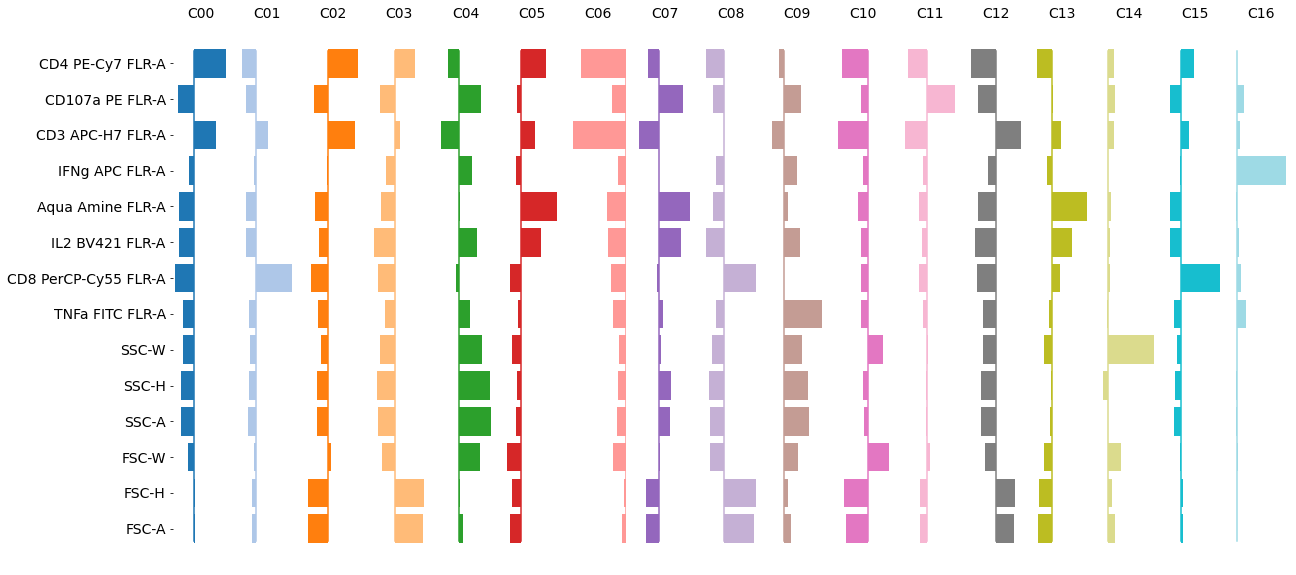

In [19]:
tab20 = plt.cm.get_cmap('tab20')
n, p = leiden_clusters.shape

fig, axes = plt.subplots(1, n, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    ax.barh(range(p), leiden_clusters.iloc[i,:], color=tab20(int(i*(20+1)/n)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_title(f'C{i:02d}', fontsize=14)
    ax.axvline(0, c=tab20(int(i*(20+1)/n)), ymin=0.05, ymax=0.95)
    
    if i == 0:
        ax.set_yticks(range(p))
        ax.set_yticklabels(leiden_clusters.columns,fontsize=14)

### Apply dimension reduction using PaCMAP

In [20]:
embedder = pacmap.PaCMAP()

In [21]:
X2 = embedder.fit_transform(X_scaled)

In [22]:
min_max_scaler = MinMaxScaler()
X2 = min_max_scaler.fit_transform(X2)

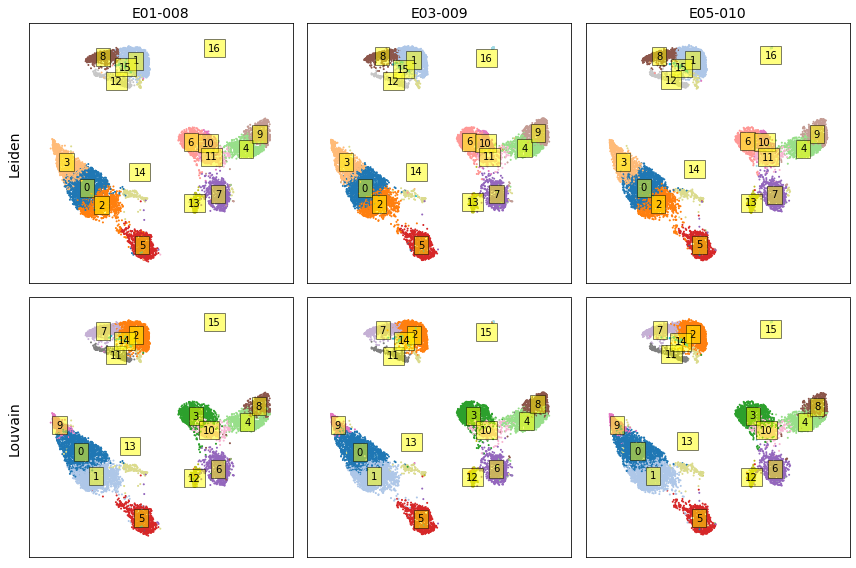

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (community, title) in enumerate(zip(communities, titles)):
    for j in range(3):
        z = community[(j*k):(j+1)*k]
        x = X2[(j*k):(j+1)*k, 0]
        y = X2[(j*k):(j+1)*k, 1]
        
        ax = axes[i, j]
        ax.scatter(x, y, s=1, c=z, cmap='tab20')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
        if j==0:
            ax.set_ylabel(title, fontsize=14)
        if i==0:
            ax.set_title('-'.join(sample_ids[j].split('_')[3:5]), fontsize=14)
            
        for idx in np.unique(z):
            x_, y_ = x[z==idx], y[z==idx]
            x_c, y_c = np.mean(x_), np.mean(y_)
            
            ax.text(
                x_c, 
                y_c, 
                str(idx), 
                va='center', 
                ha='center', 
                bbox=dict(fc='yellow', alpha=0.5)
            )
            
plt.tight_layout()